In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

%env CUDA_VISIBLE_DEVICES=0
import torch
import torchvision as tv
from torchvision import datasets, transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import math

import time
import wavio

import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import scipy.signal as spsig

from sklearn.linear_model import Lasso
import copy

env: CUDA_VISIBLE_DEVICES=0


In [2]:
wave = wavio.read("audio_data/offer_8192hz_2s.wav")
WAVE_RATE = wave.rate
WAVE_LEN = wave.data.shape[0]
WAVE_RES = wave.sampwidth
nc = wave.data.shape[1]
y0 = wave.data

print("Sampling Rate: ", WAVE_RATE)
print("Num Samples: ", WAVE_LEN)
print("Clip Length: ", round(WAVE_LEN/(1.0*WAVE_RATE), 2))
print("Bits/Sample: ", 8*WAVE_RES)
print("Num Channels: ", nc)

Sampling Rate:  8192
Num Samples:  16384
Clip Length:  2.0
Bits/Sample:  16
Num Channels:  1


In [3]:
compressed = True
compressed_noisy = False

if compressed:
    num_measurements = 1000
else:
    num_measurements = WAVE_LEN

normalised = True
scaled = not normalised

In [4]:
#ugly solution for maintaining wave's original stats 
def get_stats(x):
    chans = x.shape[1]
    
    maxes = np.zeros((chans))
    mins = np.zeros((chans))
    mu = np.zeros((chans))
    sigma = np.zeros((chans))
    power = np.zeros((chans), dtype = float)
    
    for c in range(chans):
        mu[c] = np.mean(x[:,c])
        sigma[c] = np.std(x[:,c])
        maxes[c] = np.max(x[:,c])
        mins[c] = np.min(x[:,c])
        power[c] = np.mean(np.array(x[:,c], dtype = float)**2)
    
    return [mu, sigma, mins, maxes, power]

MU, SIGMA, MINS, MAXES, POWER = get_stats(y0)

#Transforms distribution of signal amplitudes to be Gaussian(0,1)
def normalise(x, mean, std):
    normalised = np.zeros((x.shape))
    chans = x.shape[1]
    
    for c in range(chans):
        #normalised[:,c] = (x[:,c] - mean[c])/std[c]
        normalised[:,c] = x[:,c]/32768
        
    return normalised

#Transforms distribution of signal amplitudes from Gaussian(0,1) back to original 
def renormalise(x, mean, std):
    renormalised = np.zeros((x.shape))
    chans = x.shape[1]
    
    for c in range(chans):
        #renormalised[:,c] = (x[:,c] * std[c]) + mean[c]
        renormalised[:,c] = x[:,c]*32768
        
    return renormalised

#linearly scales a signal's range: [a, b] --> [-1, 1]
def scale(x, mins, maxes):
    chans = x.shape[1]
    scaled = np.zeros((x.shape))
    
    for c in range(chans):
        translate = (mins[c] + maxes[c])/2.0
        scale = (maxes[c] - mins[c])/2.0
        
        scaled[:,c] = (x[:,c] - translate)/scale 
    
    return scaled
        
#linearly scales a signal's range: [-1, 1] --> [a, b]
def rescale(x, mins, maxes):
    chans = x.shape[1]
    rescaled = np.zeros((x.shape))
    
    for c in range(chans):
        translate = (mins[c] + maxes[c])/2.0
        scale = (maxes[c] - mins[c])/2.0
        
        rescaled[:,c] = (x[:,c] * scale) + translate
    
    return rescaled

print("Means: ", MU)
print("STD: ", SIGMA)
print("Mins: ", MINS)
print("Maxes: ", MAXES)
print("POWER: ", POWER)

if normalised:
    y = normalise(y0, MU, SIGMA)
elif scaled:
    y = scale(y0, MINS, MAXES)

Means:  [-1689.41662598]
STD:  [4976.45596977]
Mins:  [-32768.]
Maxes:  [32767.]
POWER:  [27619242.55517578]


In [5]:
if compressed:
    if not compressed_noisy:
        kept_samples = random.sample(range(0, WAVE_LEN*nc), num_measurements) #randomly select num_measurements samples to keep
        A = spfft.idct(np.identity(WAVE_LEN*nc), norm='ortho', axis=0)[kept_samples,:] #grab rows corresponding to index of randomly
        if normalised or scaled:
            measurements = y[kept_samples,:]
        else:
            measurements = y0[kept_samples,:]
    else:
        samp_matrix = (1 / math.sqrt(1.0 * num_measurements)) * np.random.randn(num_measurements, WAVE_LEN * nc)
        A = np.matmul(samp_matrix, spfft.idct(np.identity(WAVE_LEN*nc), norm = 'ortho', axis=0))
        if normalised or scaled:
            measurements = np.matmul(samp_matrix, y)
        else:
            measurements = np.matmul(samp_matrix, y0)
else:
    A = spfft.idct(np.identity(WAVE_LEN*nc), norm='ortho', axis=0)
    if normalised or scaled:
        measurements = y
    else:
        measurements = y0
    
print(A.shape)
print(measurements.shape)

(1000, 16384)
(1000, 1)


In [6]:
lasso = Lasso(alpha = 1e-5)
lasso.fit(A, measurements)

x_hat = np.array(lasso.coef_).reshape(WAVE_LEN*nc)
x_hat = spfft.idct(x_hat, norm = 'ortho', axis=0)
x_hat = x_hat.reshape(-1,nc)

if normalised:
    x_hat = renormalise(x_hat, MU, SIGMA)
elif scaled:
    x_hat = rescale(x_hat, MINS, MAXES)

In [7]:
print(y0.shape)
print(x_hat.shape)

(16384, 1)
(16384, 1)


In [8]:
mse = np.mean((np.squeeze(x_hat) - np.squeeze(y0))**2)/POWER[0]
print(mse)

1.1176963907717818


In [9]:
#wavio.write("Lasso_best.wav", x_hat, WAVE_RATE, sampwidth=WAVE_RES)

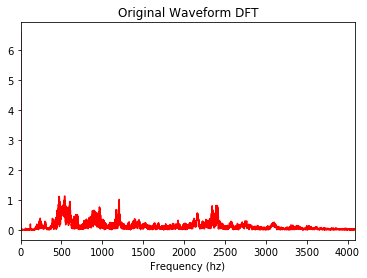

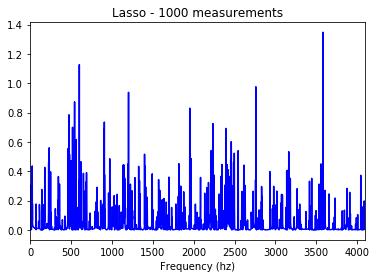

In [10]:
spectrum =np.fft.fft(y[:,0], norm = 'ortho')
spectrum = abs(spectrum[0:round(len(spectrum)/2)]) # Just first half of the spectrum, as the second is the negative copy

plt.figure()
plt.plot(spectrum, 'r')
plt.xlabel('Frequency (hz)')
plt.title('Original Waveform DFT')
plt.xlim(0,WAVE_RATE/2)
#plt.ylim(0,np.max(spectrum))
plt.show()

if normalised:
    result = np.fft.fft(normalise(x_hat, MU, SIGMA)[:,0], norm='ortho')
elif scaled:
    result = np.fft.fft(scale(x_hat, MINS, MAXES)[:,0], norm='ortho')
else:
    result = np.fft.fft(x_hat[:,0], norm='ortho')
result = abs(result[0:round(len(result)/2)])

plt.figure()
plt.plot(result, 'b')
plt.xlabel('Frequency (hz)')
plt.title("Lasso - " + str(num_measurements) + " measurements")
plt.xlim(0, WAVE_RATE/2)
#plt.ylim(0,np.max(result))
#plt.savefig("Freq_recon/Lasso_" + str(num_measurements) + "_testR.jpg")
plt.show()